TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color.

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc.

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


4
0.91
[1.2197802197802199, 1.1428571428571428, 1.0989010989010988, 1.054945054945055, 1.0, 0.934065934065934, 0.8901098901098902, 0.7692307692307692]
[131.61985778808594, 152.4220733642578, 159.89950561523438, 171.74655151367188, 181.11985778808594, 188.35629272460938, 196.4479217529297, 210.53005981445312]
2c
10c
10c
5c
20c
1e
50c
2e


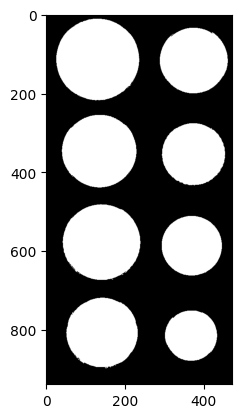

In [13]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv

img = cv2.imread('Monedas.jpg') 
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

contornos, hierarchy = cv2.findContours(img_th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)
img_cont = np.zeros(img_rgb.shape)



proporciones = [1.11, 1.04, 1, 0.96, 0.91, 0.85,  0.81, 0.7]

tipo_de_moneda = ["2e", "50c", "1e", "20c", "5c", "10c",  "2c", "1c"]

def lista_proporcional(tipo):
    pos = tipo_de_moneda.index(tipo)
    print(pos)
    valor = proporciones[pos]
    print(valor)
    tamaño_proporcional = []
    for i in proporciones:
        tamaño_proporcional.append(i/valor)
    return tamaño_proporcional

proporciones = lista_proporcional("5c")
print(proporciones)

def hallar_valor(diametro_seleccionado, diametro_nuevo, proporciones):
    proporcion_calculada = diametro_nuevo/diametro_seleccionado
    valor_mas_cercano = 1
    pos = 0
    contador = -1
    for i in proporciones:
        if (abs(proporcion_calculada - i) < valor_mas_cercano):
            valor_mas_cercano = abs(proporcion_calculada - i)
            pos = contador
        contador +=1

    return tipo_de_moneda[pos]

diametros_usar = []
donde = 0
for cnt in contornos:
    area = cv2.contourArea(cnt)
    if area > 10000:
        #print(donde)
        #print(area)
        perimetro = cv2.arcLength(cnt,True)

        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(cnt)
        #Mínimo contenedor ajustado para el contorno
        rect = cv2.minAreaRect(cnt)
        #Mínimo círculo que contiene al contorno
        (cx,cy),radio = cv2.minEnclosingCircle(cnt)
        diametros_usar.append(radio*2)
        #Elipse ajustada al contorno, exgigiendo un mínimo de puntos del contornos
        if cnt.shape[0] > 5:
            elipse = cv2.fitEllipse(cnt)
        cv2.drawContours(img_cont, [cnt], -1, (255,255,255), -1)
    donde+=1
plt.imshow(img_cont)
diametros_usar = sorted(diametros_usar)
moneda = diametros_usar[4]
print(diametros_usar)
for i in diametros_usar:
    print(hallar_valor(moneda, i, proporciones))          


TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y aprender patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test MPs_test.jpg y sus correpondientes anotaciones MPs_test_bbs.csv con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases

In [19]:
import cv2
import numpy as np

def calcular_medias_contornos(contornos, area_min=1000):
    if len(contornos) == 0:
        return (0, 0, 0, 0, 0)

    suma_area = suma_perimetro = suma_comp = suma_AR = suma_solidez = 0
    contador_validos = 0

    for cnt in contornos:
        area = cv2.contourArea(cnt)
        if area > area_min:
            perimetro = cv2.arcLength(cnt, True)
            compacidad = (perimetro ** 2) / (4 * np.pi * area) if area > 0 else 0

            x, y, w, h = cv2.boundingRect(cnt)
            AR = w / h if h > 0 else 0

            hull = cv2.convexHull(cnt)
            hull_area = cv2.contourArea(hull)
            solidez = area / hull_area if hull_area > 0 else 0

            suma_area += area
            suma_perimetro += perimetro
            suma_comp += compacidad
            suma_AR += AR
            suma_solidez += solidez
            contador_validos += 1

    if contador_validos == 0:
        contador_validos = 1
    return (
        suma_area / contador_validos,
        suma_perimetro / contador_validos,
        suma_comp / contador_validos,
        suma_AR / contador_validos,
        suma_solidez / contador_validos
    )


img_fragments = cv2.imread("FRA.png")
img_pellets = cv2.imread("PEL.png")
img_tar = cv2.imread("TAR.png")


# Obtención datos fragmentos
img_gris = cv2.cvtColor(img_fragments, cv2.COLOR_BGR2GRAY)
_, img_th2 = cv2.threshold(img_gris, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contornos, _ = cv2.findContours(img_th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
area_media_frag, perimetro_media_frag, compacidad_media_frag, AR_media_frag, solidez_media_frag = calcular_medias_contornos(contornos, 100)


# Obtención datos pellets
img_gris = cv2.cvtColor(img_pellets, cv2.COLOR_BGR2GRAY)
_, img_th2 = cv2.threshold(img_gris, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contornos, _ = cv2.findContours(img_th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
area_media_pellets, perimetro_media_pellets, compacidad_media_pellets, AR_media_pellets, solidez_media_pellets = calcular_medias_contornos(contornos, 100)


# Obtención datos tar
img_gris = cv2.cvtColor(img_tar, cv2.COLOR_BGR2GRAY)
_, img_th2 = cv2.threshold(img_gris, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contornos, _ = cv2.findContours(img_th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
area_media_tar, perimetro_media_tar, compacidad_media_tar, AR_media_tar, solidez_media_tar = calcular_medias_contornos(contornos, 100)


# Resultados
print("Medias")
print(f"FRAG  -> Área: {area_media_frag:.2f}, Compacidad: {compacidad_media_frag:.2f}, AR: {AR_media_frag:.2f}, Solidez: {solidez_media_frag:.2f}")
print(f"PEL   -> Área: {area_media_pellets:.2f}, Compacidad: {compacidad_media_pellets:.2f}, AR: {AR_media_pellets:.2f}, Solidez: {solidez_media_pellets:.2f}")
print(f"TAR   -> Área: {area_media_tar:.2f}, Compacidad: {compacidad_media_tar:.2f}, AR: {AR_media_tar:.2f}, Solidez: {solidez_media_tar:.2f}")


Medias
FRAG  -> Área: 3702.50, Compacidad: 4.14, AR: 1.59, Solidez: 0.77
PEL   -> Área: 4287.85, Compacidad: 1.23, AR: 1.03, Solidez: 0.98
TAR   -> Área: 2989.44, Compacidad: 1.38, AR: 1.04, Solidez: 0.95


Anotaciones cargadas:
  label  x_min  y_min  x_max  y_max
0   TAR    503   1171    532   1186
1   TAR    204   1103    244   1133
2   TAR     16   1086     44   1118
3   TAR    524   1022    545   1048
4   TAR    408    975    433    997

Características extraídas:
    area   perimeter  compacidad        AR  solidity true_class
0  306.0   99.798990    2.590127  1.933333  0.834925        TAR
1  330.5  155.355338    5.811270  1.333333  0.381200        TAR
2  268.0  124.627417    4.611928  0.875000  0.427432        TAR
3  202.5  104.041630    4.253823  0.807692  0.448009        TAR
4  141.0  108.627417    6.659627  1.136364  0.333333        TAR

===== MÉTRICAS =====
Accuracy : 0.351
Precision: 0.123
Recall   : 0.351
F1-score : 0.182


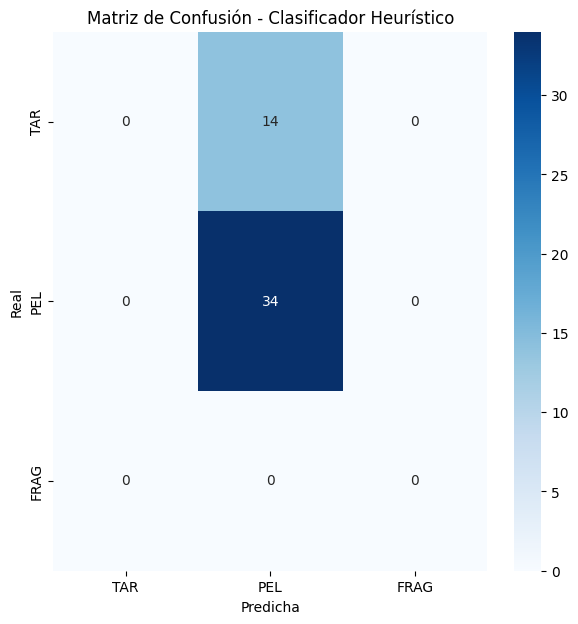


Resultados finales:
     area   perimeter  compacidad        AR  solidity true_class pred_class
0   306.0   99.798990    2.590127  1.933333  0.834925        TAR        PEL
1   330.5  155.355338    5.811270  1.333333  0.381200        TAR        PEL
2   268.0  124.627417    4.611928  0.875000  0.427432        TAR        PEL
3   202.5  104.041630    4.253823  0.807692  0.448009        TAR        PEL
4   141.0  108.627417    6.659627  1.136364  0.333333        TAR        PEL
..    ...         ...         ...       ...       ...        ...        ...
92  239.0  116.627416    4.528908  0.928571  0.440147        PEL        PEL
93  271.5  109.355338    3.505099  1.095238  0.739782        PEL        PEL
94  159.5  122.041630    7.430969  0.958333  0.315217        PEL        PEL
95  131.0   82.142135    4.098744  0.583333  0.455652        PEL        PEL
96  175.0   92.627416    3.901496  1.000000  0.492264        PEL        PEL

[97 rows x 7 columns]


In [ ]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


# Cargar imagen de test y datos
csv_path = "MPs_test_bbs.csv"

img = cv2.imread("MPs_test.jpg")

bbs = pd.read_csv(csv_path)
print("Datos cargados:")
print(bbs.head())


img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)
img_cont = np.zeros(img_rgb.shape)
# Extracción de características geométricas
features = []

for _, row in bbs.iterrows():
    # Extraer coordenadas
    x_min, y_min, x_max, y_max = map(int, [row["x_min"], row["y_min"], row["x_max"], row["y_max"]])
    true_class = row["label"]
    
    # Calcular ancho y alto
    w = x_max - x_min
    h = y_max - y_min
    
    # Recortar partícula
    roi = img[y_min:y_max, x_min:x_max]
    
    # Convertir a gris y binarizar
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Encontrar contornos
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        continue
    cnt = max(contours, key=cv2.contourArea)
    
    # Calcular características geométricas
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    compacidad = (perimeter ** 2) / (4 * np.pi * area) if area > 0 else 0
    x2, y2, w2, h2 = cv2.boundingRect(cnt)
    AR = w2 / h2 if h2 > 0 else 0
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 0

    # Guardar datos
    features.append({
        "area": area,
        "perimeter": perimeter,
        "compacidad": compacidad,
        "AR": AR,
        "solidity": solidity,
        "true_class": true_class
    })


df = pd.DataFrame(features)


# Clasificador heurístico
def clasificar(f):
    #MEJORAR LAS REGLAS DE CLASIFICACION
    if f["AR"] > 3:
        return "TAR"     # fibras alargadas
    elif f["compacidad"] > compacidad_media_frag:
        return "FRAG"    # fragmentos irregulares
    else:
        return "PEL"     # partículas redondeadas (pellets)

df["pred_class"] = df.apply(clasificar, axis=1)

# Evaluación
y_true = df["true_class"]
y_pred = df["pred_class"]

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1score = f1_score(y_true, y_pred, average="weighted", zero_division=0)

print("\n===== MÉTRICAS =====")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1-score : {f1score:.3f}")

# Matriz de confusión
labels = ["TAR", "PEL", "FRAG"]
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(7,7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicha")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Clasificador Heurístico")
plt.show()

# Resultados finales
print("\nResultados finales:")
print(df[["area", "perimeter", "compacidad", "AR", "solidity", "true_class", "pred_class"]])
